# Introduction

This Jupyter Notebook demonstrates the application of various sampling and optimization techniques in the search for polymers with desired properties. We utilize the `spacier` library for conducting Bayesian Optimization (BO) and other sampling methods to efficiently explore the material space.

## Setup and Version Check

First, we import necessary libraries and check the version of the `spacier` package to ensure compatibility and reproducibility of results.

In [1]:
import sys
sys.path.append('../')
from spacier.ml import spacier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("spacier: ", spacier.__version__)

spacier:  0.0.4


## Loading Datasets

The following function `load_datasets` is defined to load our datasets from disk. This includes the training data (`df_X`), the pool of candidates (`df_pool_X`), the known outcomes (`df`), the outcomes for the pool (`df_pool`), and the oracle or ground truth data (`df_oracle`). This setup is typical in active learning and Bayesian optimization workflows where an initial dataset is iteratively augmented with carefully selected new data.

In [2]:
def load_datasets():
    data_path = "../spacier/data"
    df_X = pd.read_csv(f"{data_path}/X.csv")
    df_pool_X = pd.read_csv(f"{data_path}/X_pool.csv")

    df = pd.read_csv(f"{data_path}/y.csv")
    df_pool = pd.read_csv(f"{data_path}/y_pool.csv")
    df_oracle = pd.read_csv(f"{data_path}//y_oracle.csv")
    
    return df_X, df_pool_X, df, df_pool, df_oracle

## Updating Datasets Function

The `update_datasets` function is designed to streamline the process of integrating new samples into our existing datasets during each iteration of our experiments. This function takes the current datasets (`df_X`, `df_pool_X`, `df`, `df_pool`), the indices of the new samples (`new_indices`), and the list of properties that need to be updated (`properties`) as inputs. It performs the following tasks:

- Selects new samples based on `new_indices` and updates the training dataset (`df_X`) and its corresponding properties (`df`).
- Removes these samples from the pool datasets (`df_pool_X`, `df_pool`) to avoid re-selection.
- Updates the properties of the selected samples in the training dataset using the oracle (`df_oracle`) to ensure accurate and updated property values.

This function returns the updated datasets, ready for the next iteration or analysis.

In [3]:
def update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_indices, properties):
    selected_polymer = df_pool.iloc[new_indices]["monomer_ID"]
    
    # Update the datasets
    df_X = pd.concat([df_X, df_pool_X.iloc[new_indices]]).reset_index(drop=True)
    df_pool_X = df_pool_X.drop(new_indices).reset_index(drop=True)

    df = pd.concat([df, df_pool.iloc[new_indices]]).reset_index(drop=True)
    df_pool = df_pool.drop(new_indices).reset_index(drop=True) 
    
    # Update properties from oracle
    for prop in properties:
        for tmp_ID in selected_polymer:
            df.loc[df['monomer_ID'] == tmp_ID, [prop]] = df_oracle[df_oracle["monomer_ID"] == tmp_ID][prop].values[0]
    
    return df_X, df_pool_X, df, df_pool

# Experiment 1: Searching for High Thermal Conductivity Polymers

In this experiment, we aim to discover polymers with high thermal conductivity. We employ the Expected Improvement (EI) method for sampling from our candidate pool, comparing its performance to random sampling. EI is a popular acquisition function in Bayesian optimization that balances exploration and exploitation by prioritizing points with a higher expected improvement over the current best observation.

In [4]:
# Experiment 1: EI
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
highest_value_ei = [0.19501973]

for num in range(20):
    new_index = spacier.BO(df_X, df_pool_X, df, "sklearn_GP", ["thermal_conductivity"]).EI(10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, ['thermal_conductivity'])
    highest_value_ei.append(df["thermal_conductivity"].max())

Number of training data :  10
Number of candidates :  1067
Number of training data :  20
Number of candidates :  1057
Number of training data :  30
Number of candidates :  1047
Number of training data :  40
Number of candidates :  1037
Number of training data :  50
Number of candidates :  1027
Number of training data :  59
Number of candidates :  1017
Number of training data :  68
Number of candidates :  1007
Number of training data :  78
Number of candidates :  997
Number of training data :  86
Number of candidates :  987
Number of training data :  96
Number of candidates :  977
Number of training data :  106
Number of candidates :  967
Number of training data :  116
Number of candidates :  957
Number of training data :  126
Number of candidates :  947
Number of training data :  136
Number of candidates :  937
Number of training data :  146
Number of candidates :  927
Number of training data :  155
Number of candidates :  917
Number of training data :  164
Number of candidates :  907


In [5]:
# Experiment 1: Random
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
highest_value_random = [0.19501973]

for num in range(20):
    new_index = spacier.Random(df_X, df_pool_X, df).sample(10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, ['thermal_conductivity'])
    highest_value_random.append(df["thermal_conductivity"].max())

Number of candidates :  1067
Number of candidates :  1057
Number of candidates :  1047
Number of candidates :  1037
Number of candidates :  1027
Number of candidates :  1017
Number of candidates :  1007
Number of candidates :  997
Number of candidates :  987
Number of candidates :  977
Number of candidates :  967
Number of candidates :  957
Number of candidates :  947
Number of candidates :  937
Number of candidates :  927
Number of candidates :  917
Number of candidates :  907
Number of candidates :  897
Number of candidates :  887
Number of candidates :  877


### Experiment 1 Plot Explanation

The plot below showcases the progress of finding polymers with high thermal conductivity over multiple cycles of sampling. It compares the effectiveness of the Expected Improvement (EI) method against a random sampling strategy. The y-axis represents the highest thermal conductivity found up to each cycle, and the x-axis tracks the number of cycles. This visualization helps to illustrate how quickly and effectively each method identifies polymers with superior thermal conductivity properties.

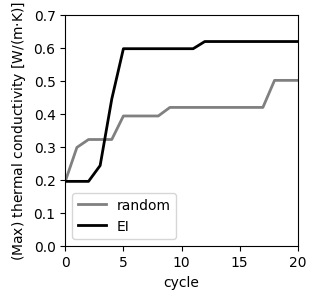

In [6]:
plt.figure(figsize=(3, 3))
plt.xlim(0, 20)
plt.ylim(0, 0.7)
plt.xlabel("cycle")
plt.ylabel(r"(Max) thermal conductivity [W/(m$\cdot$K)]")
plt.plot(np.arange(0, 21), highest_value_random, label="random", color="grey", lw=2)
plt.plot(np.arange(0, 21), highest_value_ei, label="EI", color="k", lw=2)

plt.legend()

# Experiment 2: Searching for Polymers with Specific Properties

This experiment focuses on finding polymers that fit within a specified range of properties, such as specific heat capacity (`Cp`), refractive index, and density. The Probability of Improvement (PI) method is used, which selects new samples based on the probability of those samples improving over the best current sample within the desired property ranges.

In [7]:
# Experiment 2: PI
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
hit_pi = [0]

properties_to_update = ["Cp", "refractive_index", "density"]

for num in range(20):
    new_index = spacier.BO(df_X, df_pool_X, df, "sklearn_GP", properties_to_update).PI([[3000, 4000],[1.6, 1.7], [1, 1.1]], 10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, properties_to_update)
    hit_pi.append(len(df.query("3000 < Cp < 4000 and 1.6 < refractive_index < 1.7 and 1 < density < 1.1")))

Number of training data :  10
Number of candidates :  1067
Number of training data :  20
Number of candidates :  1057
Number of training data :  30
Number of candidates :  1047
Number of training data :  40
Number of candidates :  1037
Number of training data :  50
Number of candidates :  1027
Number of training data :  60
Number of candidates :  1017
Number of training data :  70
Number of candidates :  1007
Number of training data :  80
Number of candidates :  997
Number of training data :  90
Number of candidates :  987
Number of training data :  100
Number of candidates :  977
Number of training data :  110
Number of candidates :  967
Number of training data :  120
Number of candidates :  957
Number of training data :  130
Number of candidates :  947
Number of training data :  140
Number of candidates :  937
Number of training data :  150
Number of candidates :  927
Number of training data :  160
Number of candidates :  917
Number of training data :  170
Number of candidates :  907

In [8]:
# Experiment 2: Random
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
hit_random = [0]

for num in range(20):
    new_index = spacier.Random(df_X, df_pool_X, df).sample(10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, properties_to_update)
    hit_random.append(len(df.query("3000 < Cp < 4000 and 1.6 < refractive_index < 1.7 and 1 < density < 1.1")))

Number of candidates :  1067
Number of candidates :  1057
Number of candidates :  1047
Number of candidates :  1037
Number of candidates :  1027
Number of candidates :  1017
Number of candidates :  1007
Number of candidates :  997
Number of candidates :  987
Number of candidates :  977
Number of candidates :  967
Number of candidates :  957
Number of candidates :  947
Number of candidates :  937
Number of candidates :  927
Number of candidates :  917
Number of candidates :  907
Number of candidates :  897
Number of candidates :  887
Number of candidates :  877


### Experiment 2 Plot Explanation

This plot demonstrates the efficiency of the Probability of Improvement (PI) method compared to random sampling in identifying polymers within a specified range of properties (specific heat capacity, refractive index, and density). The plot tracks the cumulative number of polymers found that meet the desired criteria over successive sampling cycles. The goal is to highlight the method's ability to zone in on the target property space more efficiently than random chance.

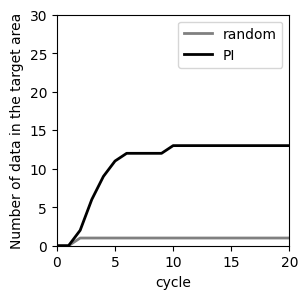

In [9]:
plt.figure(figsize=(3, 3))
plt.xlim(0, 20)
plt.ylim(0, 30)
plt.xlabel("cycle")
plt.ylabel("Number of data in the target area")
plt.plot(np.arange(0, 21), hit_random, label="random", color="grey", lw=2)
plt.plot(np.arange(0, 21), hit_pi, label="PI", color="k", lw=2)
plt.legend()

# Experiment 3: Pareto Front Exploration

In our third experiment, we explore the Pareto front of polymers based on two competing properties: heat capacity (`Cp`) and refractive index. The Expected Hypervolume Improvement (EHVI) method is a multi-objective optimization technique used here to select new samples that are expected to contribute most to the expansion of the Pareto front. We compare its efficacy against random sampling in identifying true Pareto-optimal solutions.

In [10]:
# Identifying the Pareto Front
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
PF = spacier.PF_max(df_oracle["Cp"].values, df_oracle["refractive_index"].values)
PF_idx = []
for num in range(len(PF)):
    prop1 = PF[num][0]
    prop2 = PF[num][1]
    tmp = (df_oracle["Cp"]-prop1).abs() + (df_oracle["refractive_index"]-prop2).abs() 
    index = df_oracle.index[tmp.argsort()][0].tolist()
    PF_idx.append(df_oracle.iloc[index]["monomer_ID"])

In [11]:
# Experiment 3: EHVI
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
hit_ehvi = [0]

properties_to_update = ["Cp", "refractive_index"]

for num in range(20):
    new_index = spacier.BO(df_X, df_pool_X, df, "sklearn_GP", properties_to_update, standardization=True).EHVI(10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, properties_to_update)
    hit_ehvi.append(len(set(list(df["monomer_ID"])) & set(PF_idx)))

Number of training data :  10
Number of candidates :  1067
Number of training data :  20
Number of candidates :  1057
Number of training data :  30
Number of candidates :  1047
Number of training data :  40
Number of candidates :  1037
Number of training data :  50
Number of candidates :  1027
Number of training data :  60
Number of candidates :  1017
Number of training data :  70
Number of candidates :  1007
Number of training data :  80
Number of candidates :  997
Number of training data :  90
Number of candidates :  987
Number of training data :  100
Number of candidates :  977
Number of training data :  110
Number of candidates :  967
Number of training data :  120
Number of candidates :  957
Number of training data :  130
Number of candidates :  947
Number of training data :  140
Number of candidates :  937
Number of training data :  150
Number of candidates :  927
Number of training data :  160
Number of candidates :  917
Number of training data :  170
Number of candidates :  907

In [12]:
# Experiment 3: Random
df_X, df_pool_X, df, df_pool, df_oracle = load_datasets()
hit_random = [0]

for num in range(20):
    new_index = spacier.Random(df_X, df_pool_X, df).sample(10)
    df_X, df_pool_X, df, df_pool = update_datasets(df_X, df_pool_X, df, df_pool, df_oracle, new_index, properties_to_update)
    hit_random.append(len(set(list(df["monomer_ID"])) & set(PF_idx)))

Number of candidates :  1067
Number of candidates :  1057
Number of candidates :  1047
Number of candidates :  1037
Number of candidates :  1027
Number of candidates :  1017
Number of candidates :  1007
Number of candidates :  997
Number of candidates :  987
Number of candidates :  978
Number of candidates :  968
Number of candidates :  958
Number of candidates :  948
Number of candidates :  938
Number of candidates :  928
Number of candidates :  918
Number of candidates :  908
Number of candidates :  898
Number of candidates :  888
Number of candidates :  878


### Experiment 3 Plot Explanation

In the final experiment, we explore the Pareto front for polymers based on two competing properties: heat capacity (`Cp`) and refractive index. The plot compares the Expected Hypervolume Improvement (EHVI) method against random sampling in terms of discovering true Pareto-optimal solutions over multiple cycles. The number of Pareto solutions found is plotted against the cycle number, illustrating each method's effectiveness in navigating the trade-offs between these two properties to uncover optimal polymers.

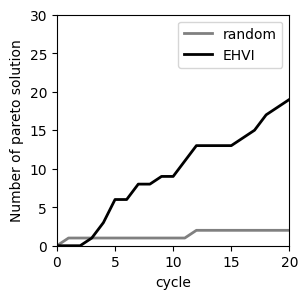

In [13]:
plt.figure(figsize=(3, 3))
plt.xlim(0, 20)
plt.ylim(0, 30)
plt.xlabel("cycle")
plt.ylabel("Number of pareto solution")
plt.plot(np.arange(0, 21), hit_random, label="random", color="grey", lw=2)
plt.plot(np.arange(0, 21), hit_ehvi, label="EHVI", color="k", lw=2)
plt.legend()

# Conclusion

This notebook demonstrates the application of various sampling methods in the context of materials science, leveraging the `spacier` library. By comparing methods like EI, PI, and EHVI against random sampling, we showcase the potential of Bayesian Optimization and similar strategies for efficient material discovery and optimization.